In [1]:
import torch 
import os 

%cd /workspace/Pose_3DCNN_PyTorch/project

from models.pytorchvideo_models import WalkVideoClassificationLightningModule
from dataloader.data_loader import WalkDataModule

from pytorch_lightning import Trainer

from IPython.display import clear_output

clear_output()

from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

import torchmetrics


Global seed set to 42


In [2]:
# define the metrics.
_accuracy = torchmetrics.classification.BinaryAccuracy()
_precision = torchmetrics.classification.BinaryPrecision()
_binary_recall = torchmetrics.classification.BinaryRecall()
_binary_f1 = torchmetrics.classification.BinaryF1Score()

_confusion_matrix = torchmetrics.classification.BinaryConfusionMatrix()

_aucroc = torchmetrics.classification.BinaryAUROC()

In [36]:
from parameters import get_parameters

VIDEO_LENGTH = ['1']
VIDEO_FRAME = ['30']


opt, _ = get_parameters()
opt.num_workers = 8
opt.batch_size = 8
opt.gpu_num = 1

opt.version = '119_1_10'
opt.model = "resnet"
opt.model_depth = 50
opt.model_class_num = 1

opt.version = opt.version + '_' + opt.model + '_depth' + str(opt.model_depth)

opt.transfor_learning = True
opt.pre_process_flag = True
opt.part = 'body'

DATA_PATH = opt.pose_data_path


In [4]:
def get_best_ckpt(version:str, length: str, frame: str, fold: str):

    ckpt_path = '/workspace/Pose_3DCNN_PyTorch/logs/resnet'
    ckpt_path_list = os.listdir(ckpt_path)
    ckpt_path_list.sort()

    final_ckpt_list = [] 

    data = version.split('_')[0]

    for i in ckpt_path_list:
        if len(i) < 25:
            final_ckpt_list.append(i)

    final_ckpt_list.sort()
    
    for name in final_ckpt_list:
        if length in name.split('_') and frame in name.split('_') and data in name.split('_'):
            ckpt = name

    ckpt = os.path.join(ckpt_path, ckpt, fold, 'checkpoints')
    
    Acc = 0.0

    ckpt_list = os.listdir(ckpt)
    ckpt_list.sort()
    ckpt_list.remove('last.ckpt')

    for num, l in enumerate(ckpt_list):
        acc = l[-11:-5] # accuracy

        if float(acc) > float(Acc):
            Acc = acc
            NUM = num

    return os.path.join(ckpt, ckpt_list[NUM])

# ckpt_path = get_best_ckpt(opt.version, '1', '10', 'fold0')


In [19]:
def get_inference(test_data, model):
        
    pred_list = []
    label_list = []

    dict_of_loaders = test_data.loaders
    test_dl1 = dict_of_loaders['body']

    for i, batch in enumerate(test_dl1):

        # input and label
        video = batch['video'].detach().cuda() # b, c, t, h, w

        label = batch['label'].detach().cuda() # b, class_num

        model.cuda().eval()

        # pred the video frames
        with torch.no_grad():
            preds = model(video)

        # when torch.size([1]), not squeeze.
        if preds.size()[0] != 1 or len(preds.size()) != 1 :
            preds = preds.squeeze(dim=-1)
            preds_sigmoid = torch.sigmoid(preds)
        else:
            preds_sigmoid = torch.sigmoid(preds)

        pred_list.append(preds_sigmoid.tolist())
        label_list.append(label.tolist())

        total_pred_list = []
        total_label_list = []

        for i in pred_list:
            for number in i:
                total_pred_list.append(number)

        for i in label_list:
            for number in i: 
                total_label_list.append(number)

    pred = torch.tensor(total_pred_list)
    label = torch.tensor(total_label_list)

    return pred, label

# pred_list, label_list = get_inference(test_data, model)

In [37]:
fold_num = os.listdir(DATA_PATH)
fold_num.sort()
fold_num.remove('raw')

symbol = '_'

for length in VIDEO_LENGTH:

    for frame in VIDEO_FRAME:

        one_condition_pred_list = []
        one_condition_label_list = []

        total_pred_list = []
        total_label_list = []

        for fold in fold_num:

            opt.train_path = os.path.join(DATA_PATH, fold)

            #################
            # start k Fold CV
            #################
            
            opt.clip_duration = int(length)
            opt.uniform_temporal_subsample_num = int(frame)
           
            ckpt_path = get_best_ckpt(opt.version, length, frame, fold)

            print('#' * 50)
            print('Strat %s, %s length, %s frames' % (fold, length, frame))
            print('the data path: %s' % opt.train_path)
            print('ckpt: %s' % ckpt_path)
            model = WalkVideoClassificationLightningModule(opt).load_from_checkpoint(ckpt_path)

            data_module = WalkDataModule(opt)
            data_module.setup()
            test_data = data_module.val_dataloader()

            pred_list, label_list = get_inference(test_data, model)

            one_condition_pred_list.append(pred_list)

            one_condition_label_list.append(label_list)

        # total 5 fold pred and label
        for i in one_condition_pred_list:
            for number in i:
                total_pred_list.append(number)

        for i in one_condition_label_list:
            for number in i: 
                total_label_list.append(number)

        pred = torch.tensor(total_pred_list)    
        label = torch.tensor(total_label_list)

        print('*' * 100)
        print('the result of %ss %sframe:' % (length, frame))
        print('accuracy: %s' % _accuracy(pred, label))
        print('precision: %s' % _precision(pred, label))
        print('_binary_recall: %s' % _binary_recall(pred, label))
        print('_binary_f1: %s' % _binary_f1(pred, label))
        print('_aurroc: %s' % _aucroc(pred, label))
        print('_confusion_matrix: %s' % _confusion_matrix(pred, label))
        print('#' * 50)


##################################################
Strat fold0, 1 length, 30 frames
the data path: /workspace/data/Pose_dataset_512/fold0
ckpt: /workspace/Pose_3DCNN_PyTorch/logs/resnet/119_1_30_resnet_depth50/fold0/checkpoints/epoch=3-val_loss=0.87-val_acc=0.7318.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model!
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold0/body/train
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold0/body/val
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold0/body/val
##################################################
##################################################
Strat fold1, 1 length, 30 frames
the data path: /workspace/data/Pose_dataset_512/fold1
ckpt: /workspace/Pose_3DCNN_PyTorch/logs/resnet/119_1_30_resnet_depth50/fold1/checkpoints/epoch=0-val_loss=0.50-val_acc=0.8021.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model!
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold1/body/train
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold1/body/val
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold1/body/val
##################################################
##################################################
Strat fold2, 1 length, 30 frames
the data path: /workspace/data/Pose_dataset_512/fold2
ckpt: /workspace/Pose_3DCNN_PyTorch/logs/resnet/119_1_30_resnet_depth50/fold2/checkpoints/epoch=2-val_loss=0.93-val_acc=0.7656.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model!
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold2/body/train
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold2/body/val
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold2/body/val
##################################################
##################################################
Strat fold3, 1 length, 30 frames
the data path: /workspace/data/Pose_dataset_512/fold3
ckpt: /workspace/Pose_3DCNN_PyTorch/logs/resnet/119_1_30_resnet_depth50/fold3/checkpoints/epoch=6-val_loss=0.09-val_acc=0.9714.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model!
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold3/body/train
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold3/body/val
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold3/body/val
##################################################
##################################################
Strat fold4, 1 length, 30 frames
the data path: /workspace/data/Pose_dataset_512/fold4
ckpt: /workspace/Pose_3DCNN_PyTorch/logs/resnet/119_1_30_resnet_depth50/fold4/checkpoints/epoch=4-val_loss=1.65-val_acc=0.7760.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model!
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold4/body/train
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold4/body/val
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold4/body/val
##################################################
****************************************************************************************************
the result of 1s 30frame:
accuracy: tensor(0.8062)
precision: tensor(0.9350)
_binary_recall: tensor(0.6275)
_binary_f1: tensor(0.7510)
_aurroc: tensor(0.8487)
_confusion_matrix: tensor([[987,  39],
        [333, 561]])
##################################################


In [20]:
fold = 'fold0'
length = '1'
frame = '10'


opt.clip_duration = int(length)
opt.uniform_temporal_subsample_num = int(frame)
opt.train_path = os.path.join(DATA_PATH, fold)
opt.version = '119_1_10'

ckpt_path = get_best_ckpt(opt.version, length, frame, fold)

print('#' * 50)
print('Strat %s, %s length, %s frames' % (fold, length, frame))
print('the data path: %s' % opt.train_path)
print('ckpt: %s' % ckpt_path)
model = WalkVideoClassificationLightningModule(opt).load_from_checkpoint(ckpt_path)

data_module = WalkDataModule(opt)
data_module.setup()
test_data = data_module.val_dataloader()

pred, label = get_inference(test_data, model)

print('accuracy: %s' % _accuracy(pred, label))
print('precision: %s' % _precision(pred, label))
print('_binary_recall: %s' % _binary_recall(pred, label))
print('_confusion_matrix: %s' % _confusion_matrix(pred, label))
print('#' * 50)

##################################################
Strat fold0, 1 length, 10 frames
the data path: /workspace/data/Pose_dataset_512/fold0
ckpt: /workspace/Pose_3DCNN_PyTorch/logs/resnet/119_1_10_resnet_depth50/fold0/checkpoints/epoch=10-val_loss=0.59-val_acc=0.8099.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model!
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold0/body/train
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold0/body/val
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold0/body/val
##################################################
accuracy: tensor(0.7812)
precision: tensor(0.9358)
_binary_recall: tensor(0.5698)
_confusion_matrix: tensor([[198,   7],
        [ 77, 102]])
##################################################


In [22]:
_aucroc(pred, label)

tensor(0.9069)

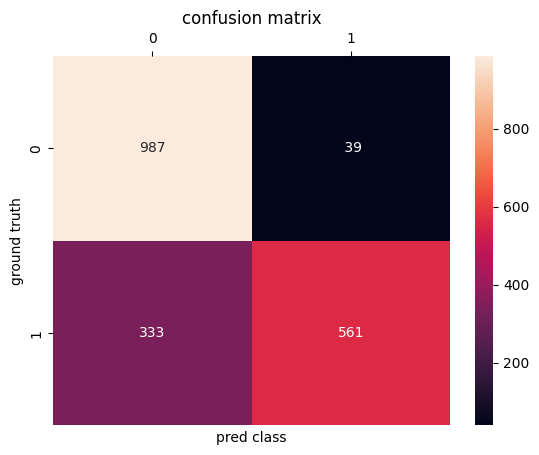

<Figure size 640x480 with 0 Axes>

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = _confusion_matrix(pred, label)

ax = sns.heatmap(cm, annot=True, fmt="3d")

ax.set_title('confusion matrix')
ax.set(xlabel="pred class", ylabel="ground truth")
ax.xaxis.tick_top()
plt.show()
plt.savefig('test.png')


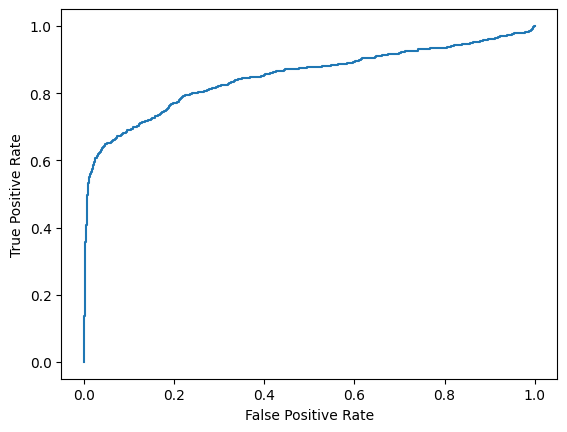

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay


fpr, tpr, _ = roc_curve(label, pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

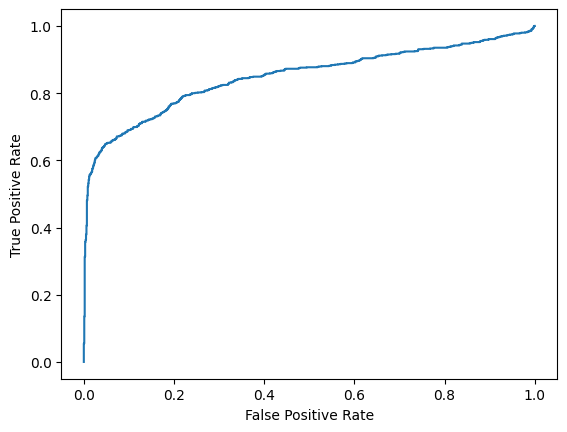

In [40]:
metric = torchmetrics.classification.BinaryROC(thresholds=None)
fpr, tpr, thd = metric(pred, label)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

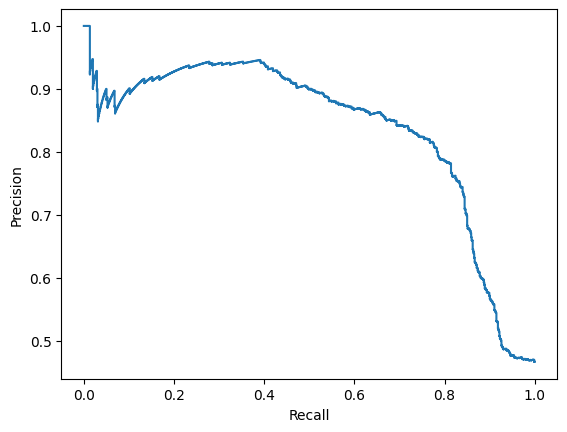

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(label, pred, pos_label=1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

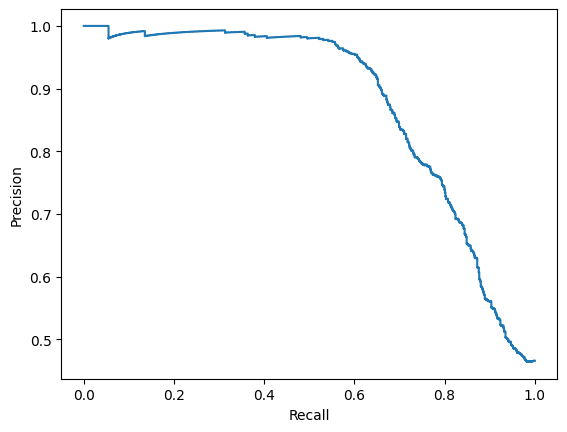

In [42]:
metric = torchmetrics.classification.BinaryPrecisionRecallCurve(thresholds=None)
prec, recall, threshodls = metric(pred, label)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

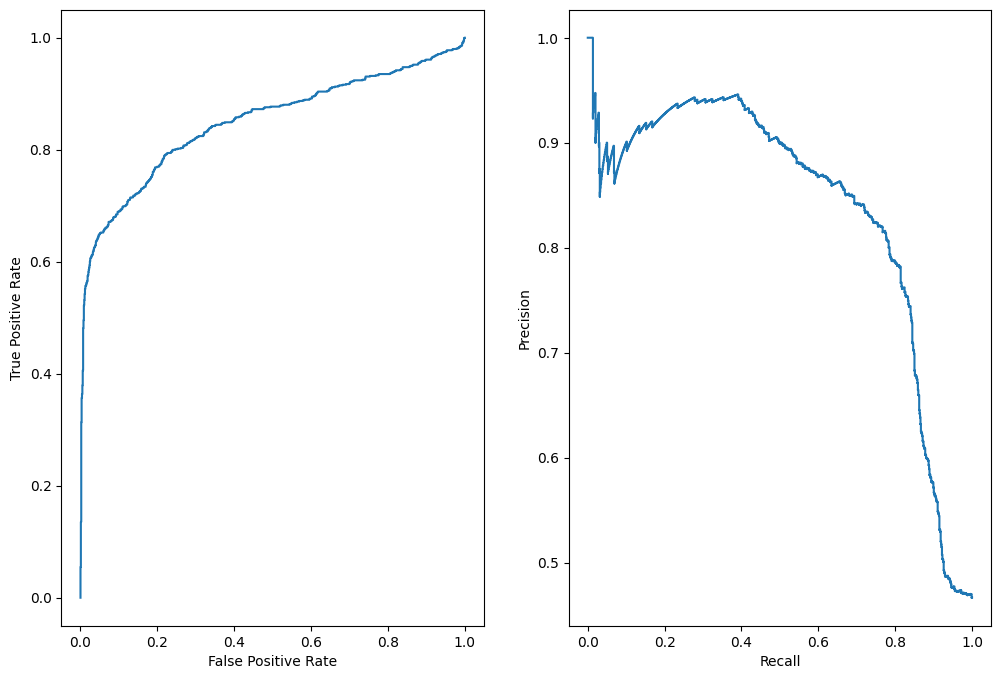

In [41]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

In [64]:
# difference between 10f and 30f

length = '1'
frame = '30'
opt.clip_duration = int(length)
opt.uniform_temporal_subsample_num = int(frame)


data_module = WalkDataModule(opt)
data_module.setup()
val_data = data_module.val_dataloader()

dict_of_loaders = val_data.loaders
test_dl1 = dict_of_loaders['body']

batch = next(iter(test_dl1))

from torchvision.io.video import write_video

write_video('_'.join([length, frame])+'.mp4', batch['video'][0].permute(1,2,3,0), fps=30)

##################################################
run pre process model!
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold4/body/train
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold4/body/val
##################################################
##################################################
load path: /workspace/data/Pose_dataset_512/fold4/body/val
##################################################


torch.Size([8, 3, 30, 224, 224])